# Getting Started

This guide introduces the basic functionality of this package in a step by step manner.  This is a good starting point for learning about how to use this package.  For more details about how to use a particular model or coupling, refer to the documentation for that particular model or coupling.

## Installing Aeroelasticity.jl

If you haven't yet, now would be a good time to install this package.  It can be
installed from the Julia REPL by typing `]` (to enter the package manager) and then
running `add https://github.com/byuflowlab/Aeroelasticity.jl`.

Now, that the package is installed we need to load it so that we can use it.

In [1]:
using Aeroelasticity
nothing #hide

## Assembling a Coupled Model

For the purposes of this guide, we will be working with a two-degree-of-freedom typical
section model, as shown in the following figure.

![](../assets/section-drawing.svg)

Our goal is to create an 2D aeroelastic model which we can use to simulate the behavior
of this system.  For the aerodynamic model, we will be using Peters' finite state model
(see `Peters`).  For the structural model, we will be using a two degree of
freedom typical section model (see `Section`).  To assemble an aeroelastic model
using these two models we use the `assemble_model` function.

In [2]:
model = assemble_model(
    aerodynamic_model = Peters{4}(),
    structural_model = Section())

nothing #hide

## Defining Model Parameters

Model parameters are defined using the `assemble_parameters` function.  In
addition to the aerodynamic and structural parameters, we need to define a set of
additional parameters for the model coupling.  A description of these parameters may
be found in the documentation for each submodel and for the coupling.

In [3]:
# non-dimensional parameters
V = 1.0 # = U/(b*ωθ) (reduced velocity)
a = -1/5 # reference point normalized location
e = -1/10 # center of mass normalized location
μ = 20 # = m/(ρ*pi*b^2) (mass ratio)
r2 = 6/25 # = Iθ/(m*b^2) (radius of gyration about P)
σ = 2/5 # = ωh/ωθ (natural frequency ratio)
xθ = e - a # normalized distance from the reference point to the center of mass
a0 = 2*pi # lift curve slope
α0 = 0 # zero lift angle
cd0 = 0 # zero lift drag coefficient
cm0 = 0 # zero lift moment coefficient

# chosen dimensional parameters
b = 0.5 # semi-chord
ρ = 1 # air density
ωθ = 1 # pitch natural frequency
c = 343 # air speed of sound

# dimensionalized parameters
U = V*b*ωθ # velocity
m = μ*ρ*pi*b^2 # mass
Sθ = m*xθ*b # structural imbalance
Iθ = r2*m*b^2 # moment of inertia
ωh = σ*ωθ # plunge natural frequency
kh = m*ωh^2 # linear spring constant
kθ = Iθ*ωθ^2 # torsional spring constant

p = assemble_parameters(model;
    aerodynamic_parameters = (a=a, b=b, a0=a0, alpha0=α0, cd0=cd0, cm0=cm0),
    structural_parameters = (kh=kh, ktheta=kθ, m=m, Stheta=Sθ, Itheta=Iθ),
    additional_parameters = (U=U, rho=ρ, c=c)
)

nothing #hide

## Performing a Steady State Analysis

We can find steady state solution for our model using
[`DifferentialEquations`](https://github.com/SciML/DifferentialEquations.jl).

In [4]:
using DifferentialEquations

f = ODEFunction(model)

# initial guess for state variables
x0 = zeros(number_of_states(model))

# steady state problem
prob = SteadyStateProblem(f, x0, p)

# steady state solution
x_ss = solve(prob, SSRootfind())

nothing #hide

Note that since our system is linear with respect to the state variables, the
equilibrium point of our system will be at the origin.

## Performing a Stability Analysis

The stability of a model for a given set of state variables, inputs, and parameters
may be determined by calling the `get_eigen` function, which returns
eigenvalues, left eigenvectors, and right eigenvectors.  For nonlinear systems, the
provided state variables must correspond to an equilibrium point for the stability
analysis to be theoretically valid.  Since our aeroelastic system is linear with
respect to the state variables, any set of state variables will yield the same result.

In [5]:
K, M = linearize(model, x_ss, p)

λ, U, V = get_eigen(model, K, M)

nothing #hide

A positive real part corresponding to any eigenvalue returned from the
`get_eigen` function indicates that the system is unstable for the
provided set of state variables, inputs, and parameters.

## Performing a Time Domain Simulation

We can simulate the behavior of our system using
[`DifferentialEquations.jl`](https://github.com/SciML/DifferentialEquations.jl).  Initial
state variable values and rates may be specified using the `assemble_states`
function.

In [6]:
using DifferentialEquations

# construct ODE function
f = ODEFunction(model)

# non-zero plunge degree of freedom
x0 = assemble_states(model;
    aerodynamic_states = (;lambda=zeros(4)),
    structural_states = (;h=0.5, theta=0, hdot=0, thetadot=0))

# simulate for 100 seconds
tspan = (0.0, 100.0)

# assemble problem
prob = DifferentialEquations.ODEProblem(f, x0, tspan, p)

# solve ODE problem
sol = DifferentialEquations.solve(prob)

nothing #hide

We can use DifferentialEquations' built-in interface with the
[Plots](https://github.com/JuliaPlots/Plots.jl) package to plot the simulation results.

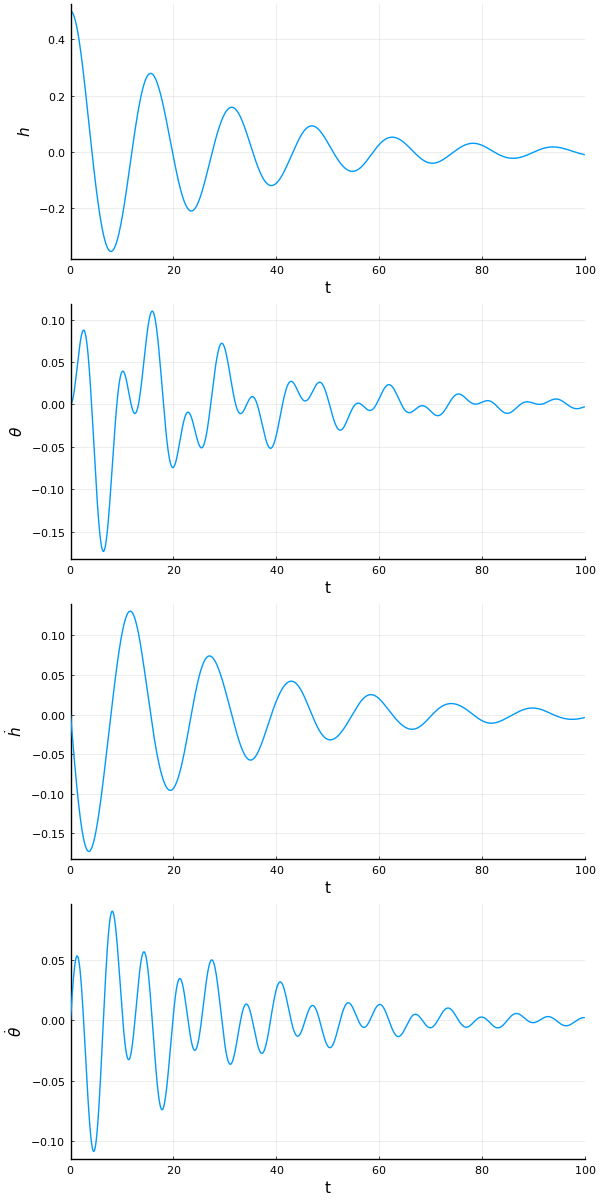

In [7]:
using Plots
pyplot()

plot(sol,
    vars = [5,6,7,8],
    xlabel = "t",
    ylabel = permutedims([
        "\$h\$",
        "\$\\theta\$",
        "\$\\dot{h}\$",
        "\$\\dot{\\theta}\$",
        ]),
    label = "",
    layout = (4, 1),
    size = (600,1200)
    )

We can also visualize the results of the typical section model using the
`section_coordinates` function.

┌ Info: Saved animation to 
└   fn = "/tmp/jl_yhPmez.gif"


Plots.AnimatedGif("/tmp/jl_yhPmez.gif")
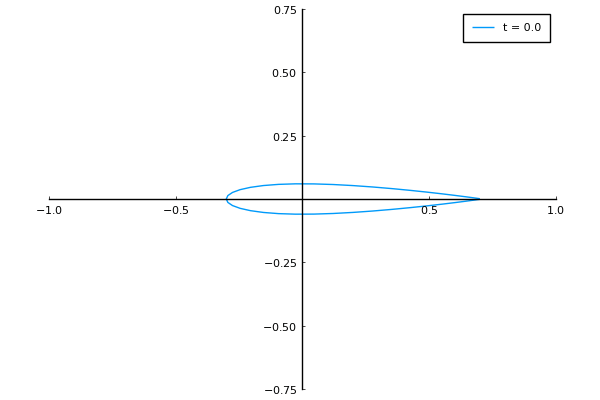

In [8]:
# animation parameters
a = -1/5
b = 0.5

# create animation
@gif for t in range(tspan[1], tspan[2], length=200)
    h, θ = sol(t, idxs=7:8)
    xplot, yplot = section_coordinates(h, θ; a, b)
    plot(xplot, yplot;
        framestyle = :origin,
        grid = :false,
        xlims = (-1.0, 1.0),
        ylims = (-0.75, 0.75),
        aspect_ratio = 1.0,
        label = "t = $(round(t, digits=1))")
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*